In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, mean_absolute_error
from sklearn.model_selection import KFold, train_test_split, cross_val_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from keras.models import Sequential
from keras.layers import Dense
import warnings
from time import time
warnings.filterwarnings(action='ignore')
import tensorflow as tf
from statistics import mode
import random

# 데이터 불러오기

In [2]:
data = pd.read_csv('data_file_csv_final.csv', encoding='utf-8')
data.drop(columns=["Unnamed: 0"],inplace=True)
data.head()

,no,cartype,receipttime,settime,ridetime,startpos1,startpos2,endpos1,endpos2,receipt,...,startlat,startlon,endlat,endlon,startplus,endplus,gotowork,gotoschool,gotocharge,end_destination
0,8075,중형 승합,2022-05-07 오전 12:08:21,2022-05-07 오전 12:15:19,2022-05-07 오전 12:30:26,22,258,11,53,2022/05/07 0:08,...,37.53,126.90,37.49,126.90,7569,7469,0,0,0,0.0
1,8231,중형승합,2022-05-07 오전 12:08:51,2022-05-07 오전 12:17:25,2022-05-07 오전 12:46:23,3,42,0,267,2022/05/07 0:08,...,37.50,126.88,37.47,126.97,7568,7469,0,0,0,0.0
2,8279,중형 승합,2022-05-07 오전 12:09:00,2022-05-07 오전 12:26:57,2022-05-07 오전 12:54:43,10,282,10,131,2022/05/07 0:09,...,37.67,127.08,37.64,127.07,7670,7670,0,0,0,0.0
3,1560,중형 승합,2022-05-07 오전 12:13:00,2022-05-07 오전 12:14:01,2022-05-07 오전 12:14:25,19,249,17,89,2022/05/07 0:13,...,37.59,127.08,37.54,127.13,7570,7571,0,0,0,0.0
4,7913,중형승합,2022-05-07 오전 12:18:00,2022-05-07 오전 1:15:54,2022-05-07 오전 1:33:16,19,90,8,173,2022/05/07 0:18,...,37.61,127.09,37.57,127.06,7670,7570,0,0,0,0.0


# 모델 생성 과정(Train/Test Split, Hyperparameter Tuning)

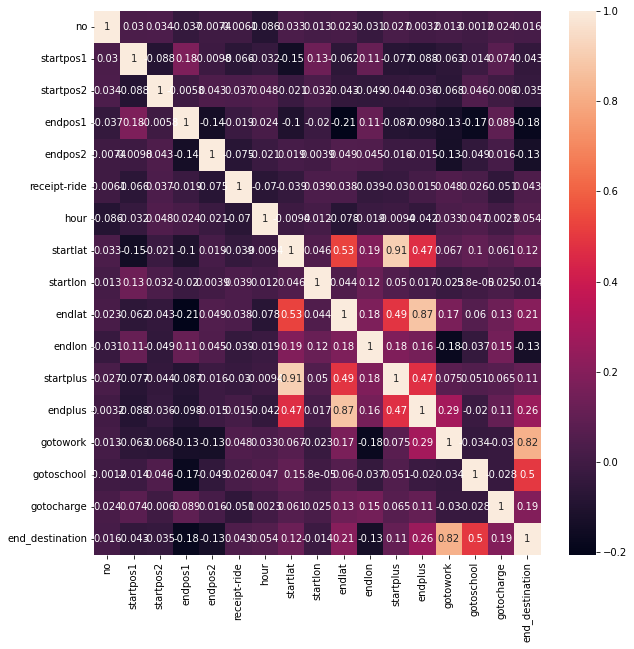

In [3]:
plt.figure(figsize=(10,10))
sns.heatmap(data.corr(), annot=True)
plt.show()

In [4]:
#data 수가 너무 적으므로 임의로 전체 데이터의 절반을 추가로 붙여주기로 함.
x=np.array(data.loc[: ,['end_destination', 'startplus',
                        'receipt-ride','hour',
                         'startpos1', 'startpos2']])
y=data['endplus']
#  data train,test로 나누기
x_train, x_test, y_train, y_test = train_test_split(
    x,y, test_size=0.1, random_state=100, shuffle=False)
print(x_train.shape)
print(x_test.shape)

(1864, 6)
(208, 6)


In [5]:
#임의로 각 모델을 정의하기
#아래로직을 통해 재정의를 함
tree_params = {
    'criterion':['gini','entropy'],
    'max_depth':[4,5,6,7,8,9,10,11,12,15,20,30,40,50,70,90,120,150],
    #'random_state' :[10, 20, 30, 42, 50, 100, 156]
}
t_grid_search = GridSearchCV(
    DecisionTreeClassifier(), 
    tree_params, 
)
d_grid_result = t_grid_search.fit(x_train,y_train)
best_d_clf = t_grid_search.best_estimator_
best_d_clf.fit(x_train, y_train)
best_k_clf = KNeighborsClassifier()
best_r_clf = RandomForestClassifier()
best_ada_clf = AdaBoostClassifier(
    base_estimator=best_d_clf,
    n_estimators=10,
    learning_rate=0.1
)
best_gb_clf = GradientBoostingClassifier()

In [6]:
#### hyperparameter를 여러개로 바꿔서 
#다시 KNeighborsClassifier 수행하기
k_params = {
    'n_neighbors' : [3, 5, 7, 9, 11],
    'weights' : ['uniform', 'distance'],
    'metric' : ['euclidean', 'manhattan']
}
k_grid_search = GridSearchCV(
    estimator=best_k_clf, 
    param_grid=k_params, 
    n_jobs=-1, 
    verbose = 1
)

In [7]:
#### hyperparameter를 여러개로 바꿔서 
#다시 RandomforestClassifier 수행하기
r_params = {
    'n_estimators'      : [320,330,340],
    'max_depth'         : [8, 9, 10, 11, 12],
    #'random_state' : [10, 20, 30, 42, 50, 100]
}
r_grid_search = GridSearchCV(
    estimator=best_r_clf, 
    param_grid=r_params, 
    n_jobs=-1, 
)

In [8]:
#### hyperparameter를 여러개로 바꿔서 
#다시 adaboost 수행하기
ada_params = {
    'n_estimators' : [10,20,50,100,150,200, 300],
    'learning_rate' : [0.05, 0.1, 0.2, 0.3, 0.5],
    #'random_state' :[10, 20, 30, 42, 50, 100]
}
ada_grid_search = GridSearchCV(
    estimator=best_ada_clf,
    param_grid=ada_params, 
    n_jobs=-1, 
    scoring='accuracy'
)

In [9]:
#### hyperparameter를 여러개로 바꿔서 
#다시 gradientboost 수행하기
gb_params = {
    'n_estimators' : [10,20,50,100],
    'learning_rate' : [0.05, 0.1, 0.2, 0.3],
    #'random_state' :[10, 20, 30, 42, 50, 100]
}
gb_grid_search = GridSearchCV(
    estimator=best_gb_clf,
    param_grid=gb_params, 
    n_jobs=-1, 
    scoring='accuracy'
)

In [10]:
#kneighbor 다시 적용
k_grid_result = k_grid_search.fit(x_train,y_train)
print(k_grid_search.best_params_)
best_k_clf = k_grid_search.best_estimator_
best_k_clf.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


KNeighborsClassifier(metric='manhattan', weights='distance')

In [11]:
#randomforest 다시 적용
r_grid_result = r_grid_search.fit(x_train,y_train)
print(r_grid_search.best_params_)
best_r_clf = r_grid_search.best_estimator_
best_r_clf.fit(x_train, y_train)

{'max_depth': 12, 'n_estimators': 320}


RandomForestClassifier(max_depth=12, n_estimators=320)

In [12]:
#adaboost 다시 적용
ada_grid_result = ada_grid_search.fit(x_train,y_train)
print(ada_grid_search.best_params_)
best_ada_clf = ada_grid_search.best_estimator_
best_ada_clf.fit(x_train, y_train)

{'learning_rate': 0.1, 'n_estimators': 20}


AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=11),
                   learning_rate=0.1, n_estimators=20)

In [13]:
#gradientboost 다시 적용
gb_grid_result = gb_grid_search.fit(x_train,y_train)
print(gb_grid_search.best_params_)
best_gb_clf = gb_grid_search.best_estimator_
best_gb_clf.fit(x_train, y_train)

{'learning_rate': 0.3, 'n_estimators': 100}


GradientBoostingClassifier(learning_rate=0.3)

In [14]:
vo_clf = VotingClassifier(estimators=[("RF", best_r_clf),
                                        ("AC", best_ada_clf),
                                        ("KN", best_k_clf),
                                        ("GN", best_gb_clf)], voting="soft")

## 개별 분류모델 + 보팅분류모델들의 정확도 분석

In [15]:
# 정확도 
classifiers = [ best_r_clf, best_ada_clf, best_gb_clf, best_k_clf, vo_clf ]
pred_final = []
accuracy_store = []
for classifier in classifiers:
    classifier.fit(x_train, y_train)
    pred = classifier.predict(x_test)
    name = classifier.__class__.__name__
    print("{}의 예측 정확도 : {}".format(name, 
                                   round(accuracy_score(y_test, pred), 3)))
    pred_final.append(pred)
    accuracy_store.append(accuracy_score(y_test, pred))
pred_final = np.transpose(pred_final)
print("Stacking 이전 일반모델들의 예측 정확도 평균 : {}"
      .format(round(np.mean(accuracy_store), 3)))
print("Stacking 이전 일반모델 중 예측 정확도 높은 모델 : {}"
      .format(round(np.max(accuracy_store), 3)))

RandomForestClassifier의 예측 정확도 : 0.644
AdaBoostClassifier의 예측 정확도 : 0.654
GradientBoostingClassifier의 예측 정확도 : 0.678
KNeighborsClassifier의 예측 정확도 : 0.659
VotingClassifier의 예측 정확도 : 0.673
Stacking 이전 일반모델들의 예측 정확도 평균 : 0.662
Stacking 이전 일반모델 중 예측 정확도 높은 모델 : 0.678


## Stacking실시

In [16]:
# 개별 기반 모델에서 최종 메타 모델이 사용할 학습 및 테스트용 데이터를 생성
def get_stacking_base_datasets(model, X_train_n, y_train_n
                               , X_test_n, n_folds ):
    n_iter = 0
    mode_list = []
    kfold = KFold(n_splits = n_folds, shuffle = True)
    train_fold_pred = np.zeros((X_train_n.shape[0] ,1 ))
    test_pred = np.zeros((X_test_n.shape[0],n_folds))
    print(model.__class__.__name__ , ' model 시작 ')
    for train_idx, test_idx in kfold.split(X_train_n) :
        x_tr, x_te = X_train_n[train_idx], X_train_n[test_idx]
        y_tr, y_te = y_train_n[train_idx], y_train_n[test_idx]
        #print('폴드 세트: ',n_iter,' 시작 ')
        model.fit(x_tr, y_tr)
        #폴드 세트 내부에서 다시 만들어진 검증 데이터로 
        #기반 모델 예측 후 데이터 저장.
        train_fold_pred[test_idx, :] = model.predict(x_te).reshape(-1,1)
        #입력된 원본 테스트 데이터를 폴드 세트내 학습된 기반 모델에서 
        #예측 후 데이터 저장. 
        test_pred[:, n_iter] = model.predict(X_test_n)
        """print('폴드 세트 : ',n_iter,
              '\n 교차검증 정확도 : ', round(accuracy_score(
                  y_test[0:len(X_test_n)], test_pred[:, n_iter]), 3),
             )"""
        n_iter += 1
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터를 평균하여 테스트
    #test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    # 폴드 세트 내에서 원본 테스트 데이터를 예측한 데이터 최빈값 구하여 테스트
    for i in range(len(X_test_n)) :
        test_pred_mode = mode(test_pred[i, :])
        mode_list.append(test_pred_mode)
    test_pred_mean = np.reshape(mode_list, (-1, 1))
    return train_fold_pred, test_pred_mean

In [37]:
# 모델 돌리기 함수
def get_predict_datasets(X_test):
    # CV스태킹 알고리즘 각 모델에 적용
    rf_train, rf_test = get_stacking_base_datasets(best_r_clf, x_train,
                                               y_train, X_test, 10)
    kn_train, kn_test = get_stacking_base_datasets(best_k_clf, x_train, 
                                                 y_train, X_test, 10) 
    ab_train, ab_test = get_stacking_base_datasets(best_ada_clf, x_train, 
                                                 y_train, X_test, 10) 
    gn_train, gn_test = get_stacking_base_datasets(best_gb_clf, x_train, 
                                                 y_train, X_test, 10) 
    vo_train, vo_test = get_stacking_base_datasets(vo_clf, x_train, 
                                                 y_train, X_test, 10) 
    # CV스태킹 알고리즘 결과로 메타 모델 학습/시험에 필요한 
    # result_a result_b 만들기 
    Stack_final_X_train = np.concatenate((rf_train, kn_train, 
                                          ab_train, gn_train, vo_train),
                                     axis=1)
    Stack_final_X_test = np.concatenate((rf_test, kn_test,
                                         ab_test, gn_test, vo_test), 
                                     axis=1)
    return Stack_final_X_train, Stack_final_X_test

In [29]:
# 모델 완성시키는 함수
def Model(sfxtr, sfxte):
    #  개별 모델을 소프트 보팅 기반의 앙상블 모델로 구현한 분류기 
    PredictModel = VotingClassifier(estimators=[("RF", best_r_clf),
                                                ("KN", best_k_clf),
                                                ("AC", best_ada_clf),
                                                ("GN", best_gb_clf),
                                                ("VO", vo_clf),
                                               ], voting="hard")
    PredictModel.fit(sfxtr, y_train)
    predict_in = PredictModel.predict(sfxte)
    return predict_in

# 메타모델 생성 후 정확도 시각화

In [38]:
sfxtr, sfxte = get_predict_datasets(x_test)

RandomForestClassifier  model 시작 
KNeighborsClassifier  model 시작 
AdaBoostClassifier  model 시작 
GradientBoostingClassifier  model 시작 
VotingClassifier  model 시작 


In [39]:
res = Model(sfxtr, sfxte)

print('최종 메타 모델의 예측 정확도: {0:.4f}'.format(
    accuracy_score(y_test, res)))

최종 메타 모델의 예측 정확도: 0.6827


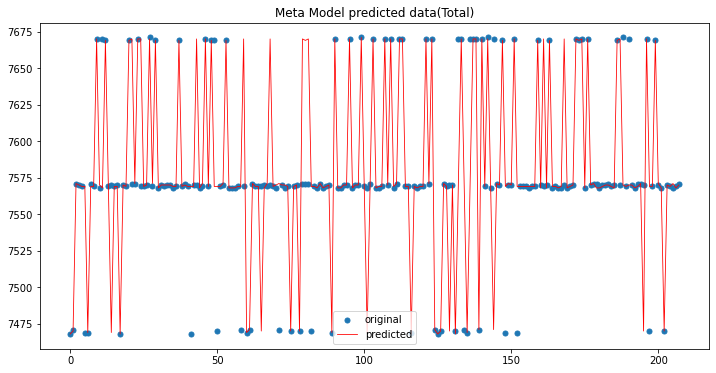

In [21]:
x_ax = range(len(y_test))
plt.rcParams["figure.figsize"] = (12,6)
plt.scatter(x_ax, y_test, label="original", alpha = 1, s = 5**2)
plt.plot(x_ax, res, lw=0.8, color="red", label="predicted")
plt.title("Meta Model predicted data(Total)")
plt.legend()
plt.show()

# 예측모델 결과

In [22]:
Test_Predict = pd.DataFrame({
    'PassengerDestination' : y_test,
    'predict' : res,
    'Success' : res == y_test
})
Test_Predict['Success'].value_counts()

True     139
False     69
Name: Success, dtype: int64

In [23]:
Test_Predict[:30]

,PassengerDestination,predict,Success
1864,7468,7468,True
1865,7471,7470,False
1866,7571,7571,True
1867,7570,7570,True
1868,7569,7569,True
1869,7469,7569,False
1870,7469,7469,True
1871,7571,7569,False
1872,7569,7569,True
1873,7670,7670,True


              precision    recall  f1-score   support

        7468       0.60      0.75      0.67         4
        7469       0.67      0.50      0.57         8
        7470       0.50      0.50      0.50         8
        7471       0.75      0.43      0.55         7
        7568       0.73      0.63      0.68        30
        7569       0.65      0.81      0.72        48
        7570       0.67      0.56      0.61        39
        7571       0.58      0.52      0.55        21
        7669       0.92      0.92      0.92        13
        7670       0.64      0.81      0.71        26
        7671       1.00      0.25      0.40         4

    accuracy                           0.67       208
   macro avg       0.70      0.61      0.63       208
weighted avg       0.68      0.67      0.66       208



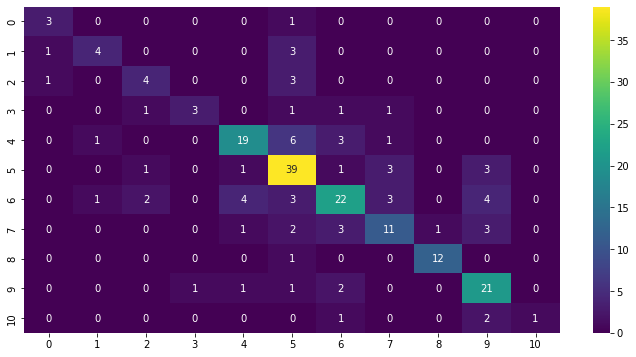

In [24]:
#분류 결과지표
cm = confusion_matrix(y_test,res)
sns.heatmap(cm,annot=True,cmap='viridis')
print(classification_report(y_test, res))

# 예측모델로 임의의 예측행렬 대입 시 결과확인

>'end_destination', 'startplus', 'receipt-ride','hour', 'startpos1', 'startpos2' 순으로 대입하면 예측결과를 얻을 수 있음
>>사용할 때 아래 코드를 통해 값을 살펴보길 바람

In [25]:
end_destination_describe = list(data['end_destination'].unique())
startplus_describe = list(data['startplus'].unique())
receipt_ride_describe = list(data['receipt-ride'].unique())
hour_describe = list(data['hour'].unique())
startpos1_describe = list(data['startpos1'].unique())
startpos2_describe = list(data['startpos2'].unique())
print('목적지값목록 : ', end_destination_describe)
print('출발지점값목록 : ', startplus_describe)
print('이용시간값목록 : ', receipt_ride_describe)
print('콜부른시간값목록 : ', hour_describe)
print('출발지(구)값목록 : ', startpos1_describe)
print('출발지(동)값목록 : ', startpos2_describe)

목적지값목록 :  [0.0, 2.0, 1.0, 3.0]
출발지점값목록 :  [7569, 7568, 7670, 7570, 7469, 7471, 7671, 7571, 7468, 7669, 7470, 7578, 7588, 7598, 7508, 7518, 7528, 7538, 7548]
이용시간값목록 :  [22, 38, 45, 1, 75, 42, 89, 69, 87, 33, 49, 43, 92, 37, 26, 15, 16, 25, 29, 13, 50, 14, 12, 3, 6, 21, 17, 19, 18, 27, 20, 23, 24, 31, 36, 40, 46, 48, 9, 11, 44, 8, 30, 28, 32, 34, 39, 10, 64, 41, 61, 35, 5, 7, 62, 70, 54, 55, 60, 56, 2, 65, 4, 91, 63, 74, 85, 52, 82, 57, 53, 59, 99, 51, 86, 58, 94, 47, 0, 111, 103, 112, 71, 77, 81, 96, 98, 79, 67, 83, 68, 114, 73, 80, 66, 72, 76, 88, 101, 121, 78, 95]
콜부른시간값목록 :  [0, 1, 2, 3, 4, 5, 7, 8, 9, 6]
출발지(구)값목록 :  [22, 3, 10, 19, 0, 13, 24, 11, 14, 20, 1, 9, 21, 15, 4, 6, 2, 17, 7, 18, 12, 23, 8, 16, 5]
출발지(동)값목록 :  [258, 42, 282, 249, 90, 306, 100, 187, 134, 98, 160, 192, 263, 185, 293, 64, 152, 308, 158, 133, 253, 284, 84, 50, 176, 203, 155, 103, 234, 60, 301, 77, 171, 201, 288, 86, 227, 189, 159, 244, 54, 177, 238, 262, 174, 32, 48, 208, 313, 126, 33, 221, 285, 58, 78, 130, 1

In [26]:
tic = time()
#input_Array = np.asarray(x_test[0 : random.randint(0,208)])
input_Array = np.asarray([[0.0, 7471, 45, 3, 20, 203]])
sfxtr_input, sfxte_input = get_predict_datasets(input_Array)
res_analysis = Model(sfxtr_input, sfxte_input)
print('예측결과 : {}'.format(res_analysis))
print("Model RunningTime done in {:.3f}s".format(time()-tic))

RandomForestClassifier  model 시작 
KNeighborsClassifier  model 시작 
AdaBoostClassifier  model 시작 
GradientBoostingClassifier  model 시작 
VotingClassifier  model 시작 
예측결과 : [7569]
Model RunningTime done in 76.279s
